# TP4


### Environment Setup

In [23]:
##### Directories #####
#Taking into account that 'TP4' is outside any folder
docs = './docs/'
input = './input/'
output = './output/'

EPH_hogar = 'EPH_usu_hogar_T123.xlsx'
EPH_individual = 'EPH_usu_individual_T123.xlsx'

In [39]:
##### Import Libraries #####
import pandas as pd
import os
from tqdm.notebook import tqdm
import numpy as np 
import matplotlib.pyplot as plt  
import statsmodels.api as sm    
import seaborn as sns 

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

## Parte 1 - Análisis de la base de hogares y cálculo de pobreza.
  Ahora que ya se han familiarizado con la Encuesta Permanente de Hogares (EPH), asegúrense de estar calculando niveles de pobreza a nivel individual y a nivel de hogar similares a los que calcula el INDEC para la misma región. Además, asegúrense de estar realizando una limpieza de la base con mayor dedicación y entendimiento de sus variables.

##### 1
  Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2023 (la base de hogares se llama [usu_hogar_T123.xls](./input/EPH_usu_hogar_T123.xlsx). Importen los datos de la encuesta de hogar y, al igual que en el TP2, conserven sólo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires.

In [29]:
#Determinamos el directorio de la base de microdatos de la EPH
eph_hog_dir = os.path.join(input, EPH_hogar)

#Leemos y copiamos dicha base
dataframe = pd.read_excel(eph_hog_dir)
df_eph_hog = dataframe.copy()

#Nos quedamos solo con las Obs de CABA y GBA (Aglomerados: 32, 33)
df_eph_hog_BsAs = df_eph_hog[df_eph_hog['AGLOMERADO'].isin([32, 33])]

#Testeamos si lo importamos correctamente:
df_eph_hog_BsAs.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,AGLOMERADO,PONDERA,IV1,...,GDECCFR,PDECCFR,ADECCFR,PONDIH,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
9,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,33,1066,1,...,12.0,NaN,12,0,1,0,98,0,0,0
10,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,33,2270,2,...,6.0,NaN,7,4733,1,0,2,0,0,0
11,TQSMNOSQRHLLTTCDEIJAH00719389,2023,1,1,1,1,S,33,2161,1,...,7.0,NaN,8,2672,1,0,98,0,0,0
35,TQRMNORTUHKOQQCDEIJAH00780489,2023,1,1,1,1,S,33,3097,1,...,8.0,NaN,9,4844,1,0,98,0,0,0
98,TQRMNOUTRHKNQMCDEIJAH00802590,2023,1,1,1,1,S,33,2571,1,...,8.0,NaN,9,3482,1,0,97,0,0,0


#### 2
 Unan la tabla de la encuesta individual con la de la encuesta de hogar. Asegúrense
de estar usando las variables CODUSU y NRO HOGAR.


In [30]:
#Determinamos el directorio de la base de microdatos de la EPH
eph_indiv_dir = os.path.join(input, EPH_individual)

#Leemos y copiamos dicha base
dataframe = pd.read_excel(eph_indiv_dir)
df_eph_indiv = dataframe.copy()
df_eph_indiv = df_eph_indiv[df_eph_indiv['AGLOMERADO'].isin([32, 33])]

df_eph_BsAs = pd.merge(df_eph_indiv, df_eph_hog, on=['CODUSU','NRO_HOGAR'], how='inner', suffixes=('_H', '_I')) #solo se queda con las rows que en ambas bases tienen el mismo CODUSU, 'right' lo haria con hogar y NaN faltantes

#Testeamos si lo importamos correctamente:
with pd.option_context('display.max_columns', None): #nos permite temporalmente sacar la restriccion al limite de cols
  df_eph_BsAs.head(10) 

In [34]:
merged_df = df_eph_BsAs.drop(df_eph_BsAs.filter(like='_I').columns, axis=1)

#### 3
 Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de valores faltantes, de outliers, como así también decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

In [35]:
def col_drop_if(drop_if_missings=False, other_criteria=[], df=merged_df):
  #dropear si cualquier valor de la lista esta en la columna
  if other_criteria:
    columns_to_drop = [col for col in df.columns if df[col].isin(other_criteria).any()]
    df = df.drop(columns=columns_to_drop)
  
  #dropear si hay missinings(valores vacios)
  if drop_if_missings:
    df.dropna(axis=1, inplace=True)

  return df

def drop_neg_obs(cols=[], df=merged_df):
  #transformamos la columna a valores numericos por las dudas
  df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
  #(Checko si es neg) => Chequeo si algun valor es negativo => If si = True => Iniverto todo con "~" y me quedo solo convalores positivos
  df = df[~(df[cols] < 0).any(axis=1)]
  return df

def replace_rename_col(col=None, replace_dic={}, new_name=None, df=merged_df):
  df[col] = df[col].replace(replace_dic)
  if new_name:
    df = df.rename(columns={col: new_name})
  return df

def categorical_to_dummy(col=None, dummy_names_dic={}, keep_old_col=False, df=merged_df):
  #le agrega a las keys del diccionario la col+"_" como prefijo --> Nos permite ser mas robusto, por si hay valores que no estan en el diccionario, generandolas con nombre identificable igualmente
  complete_dummy_names_dic = {col+ '_' + key: value for key, value in dummy_names_dic.items()}
  #Genera las dummies a partir de los valores categoricos y renombra las dummies segun el diccionario dado
  new_dummies = pd.get_dummies(df[col], prefix=col, dtype=int).rename(columns=complete_dummy_names_dic)
  
  #si keep_old_col = False => drop col vieja
  if ~keep_old_col:
      df = df.drop(columns=[col])

  #le agrega las nuevas dummies al df
  df = pd.concat([df, new_dummies], axis=1)
  return df

In [37]:
# Guardamos una copia del DataFrame original por precaución
df_eph_BsAs_clean = merged_df.copy()

# Eliminamos observaciones con valores negativos en columnas específicas
df_eph_BsAs_clean = drop_neg_obs(
                                  cols=['CH06', 'P21', 'IPCF_H', 'ITF_H', 'PP08D1'],
                                  df=df_eph_BsAs_clean)


# Eliminamos columnas con valores faltantes
df_eph_BsAs_clean = col_drop_if(
                                  drop_if_missings=True,
                                  other_criteria=[],
                                  df=df_eph_BsAs_clean)

# Reemplazamos valores en la columna 'MAS_500_H' y renombramos la columna
df_eph_BsAs_clean = replace_rename_col(
                                  col='MAS_500_H',
                                  replace_dic={'S': 1, 'N': 0},
                                  new_name='MAS_500',
                                  df=df_eph_BsAs_clean)

# Reemplazamos valores en la columna 'IV5' y renombramos la columna
df_eph_BsAs_clean = replace_rename_col(
                                  col='IV5', replace_dic={'1': 1, '2': 0},
                                  new_name='techo_revestido',
                                  df=df_eph_BsAs_clean)

# Convertimos columnas categóricas en columnas de variables dummy
categorical_list = [
{'col': 'IV3',
'dummy_names_dic': {
'1': 'pisos_revestido',
'2': 'pisos_cemento',
'3': 'pisos_sin_revestir',
'4': 'pisos_sin_especificar'
}
},
{'col': 'IV9',
'dummy_names_dic': {
'1': 'baño_adentro',
'2': 'baño_afuera',
'3': 'baño_sin'
}
},
]

for i in range(0, len(categorical_list)):
  c = categorical_list[i]
  df_eph_BsAs_clean = categorical_to_dummy(
                                  col=c['col'],
                                  dummy_names_dic=c['dummy_names_dic'],
                                  df=df_eph_BsAs_clean)

# Muestra el DataFrame resultante con todas las transformaciones
with pd.option_context('display.max_columns', None, 'display.max_rows', 10):
  display(df_eph_BsAs_clean)

,CODUSU,ANO4_H,TRIMESTRE_H,NRO_HOGAR,COMPONENTE,H15,REGION_H,MAS_500,AGLOMERADO_H,PONDERA_H,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_H,DECIFR_H,RDECIFR_H,GDECIFR_H,ADECIFR_H,IPCF_H,DECCFR_H,RDECCFR_H,GDECCFR_H,ADECCFR_H,PONDIH_H,REALIZADA,IV1,IV2,IV4,techo_revestido,IV6,IV7,IV8,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,pisos_revestido,pisos_cemento,pisos_sin_revestir,pisos_sin_especificar,IV9_0,baño_adentro,baño_afuera
0,TQRMNORUYHLMSMCDEIJAH00719364,2023,1,1,1,1,1,1,33,1545,1,2,1957-10-17 00:00:00,65,1,1.0,1,2,0,2,1,3,1,2,3,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1545,0,4,4,4.0,4,1690,60000,0,0,0,0,0,0,0,0,0,0,0,60000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0
1,TQRMNORUYHLMSMCDEIJAH00719364,2023,1,1,2,1,1,1,33,1545,2,1,1952-04-07 00:00:00,70,1,1.0,1,2,0,2,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,10000,1,1,1.0,1,3074,0,5,4,4.0,5,2910,65000,0,0,0,0,0,0,0,0,0,0,0,65000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0
2,TQRMNOSRQHJNSOCDEIJAH00802640,2023,1,1,1,1,1,1,33,8423,1,1,1986-09-26 00:00:00,36,1,4.0,1,2,0,4,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,40000,2,2,2.0,2,14906,0,2,2,2.0,2,14856,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0
3,TQRMNOSRQHJNSOCDEIJAH00802640,2023,1,1,2,1,1,1,33,8423,2,2,1994-05-02 00:00:00,28,1,4.0,1,2,0,4,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,30000,2,2,2.0,2,15878,0,2,2,2.0,2,15231,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0
4,TQRMNOSRQHJNSOCDEIJAH00802640,2023,1,1,3,0,1,1,33,8423,3,2,2014-03-20 00:00:00,9,5,4.0,1,1,1,2,2,1,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8423,0,0,0,0.0,0,8423,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,TQRMNOPVVHKLRQCDEIJAH00780546,2023,1,1,2,1,1,1,33,1236,2,2,1984-04-24 00:00:00,38,1,2.0,1,2,0,6,1,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,250000,10,10,10.0,10,1887,0,10,10,10.0,10,1954,0,0,0,0,0,0,0,0,0,0,0,0,0,480000,10,10,10.0,10,160000.00,9,9,9.0,9,2295,1,1,3,1,1,1,1,1,1,1,2,2,2,3,2,1,1,1,2,2,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,1,2,1,2,98,0,0,0,0,0,0,1,0,1,0
7614,TQRMNOPVVHKLRQCDEIJAH00780546,2023,1,1,3,0,1,1,33,1236,3,1,2013-08-05 00:00:00,9,5,2.0,1,1,2,2,2,1,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1236,0,0,0,0.0,0,1236,0,0,0,0,0,0,0,0,0,0,0,0,0,480000,10,10,10.0,10,160000.00,9,9,9.0,9,2295,1,1,3,1,1,1,1,1,1,1,2,2,2,3,2,1,1,1,2,2,2,

#### 4
 Construyan variables (mínimo 2) que no estén en la base pero que sean relevantes para predecir individuos bajo la línea de pobreza (por ejemplo, la proporción de niños en el hogar, si el cónyuge trabaja).



#### 5
 Presenten un gráfico (que no sea de barras) para describir la interacción
o correlación entre dos o más variables.


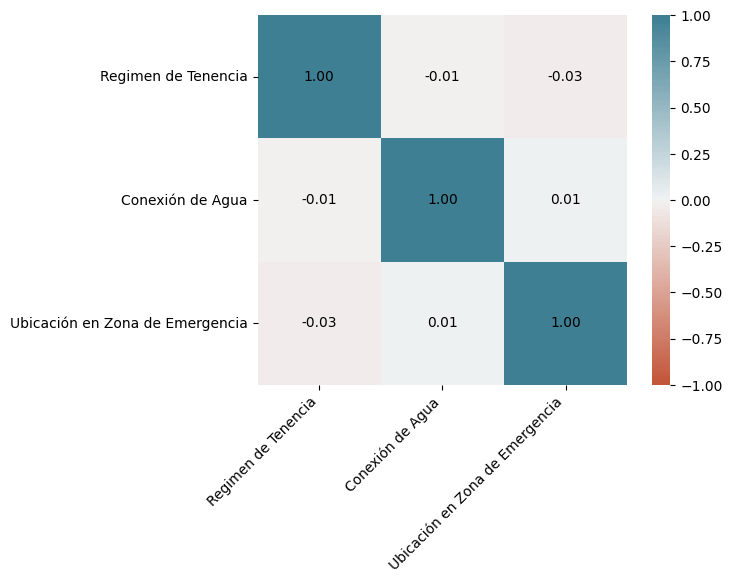

In [42]:
#Mapa de correlaciones entre variables elegidas

datos_temporal = df_eph_BsAs_clean.copy()

# Luego, renombra la columna en la copia
datos_temporal.rename


# Para restaurar el nombre original, puedes eliminar la columna renombrada de 'datos_temporal'

# datos_temporal.rename(columns={'IV5': 'Condición Interior del Techo'}, inplace=True) #AJUSTAR A NUEVA VAR
datos_temporal.rename(columns={'II7': 'Regimen de Tenencia'}, inplace=True)
datos_temporal.rename(columns={'IV6': 'Conexión de Agua'}, inplace=True)
datos_temporal.rename(columns={'IV12_3': 'Ubicación en Zona de Emergencia'}, inplace=True)
# datos_temporal.rename(columns={'IV3': 'Revestimiento del Piso'}, inplace=True) #AJUSTAR A NUEVA VAR

# Creamos una lista de las variables que queremos incluir en la matriz de correlaciones

variables_a_incluir= [
# 'Condición Interior del Techo', #AJUSTAR CON NUEVAS VAR
'Regimen de Tenencia',
'Conexión de Agua',
'Ubicación en Zona de Emergencia',
# 'Revestimiento del Piso' #AJUSTAR CON NUEVAS VAR
]


# Crear un DataFrame temporal con las variables seleccionadas
datos_temporal = datos_temporal[variables_a_incluir]

#Creamos la matriz de correlaciones
corr = datos_temporal.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)


# Usamos un for anidado para recorrer las filas y columnas de la matriz de correlación y agregar etiquetas a las celdas del mapa de calor.
for i in range(len(variables_a_incluir)):
    for j in range(len(variables_a_incluir)):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

# Establecer las etiquetas de las variables en el eje x
ax.set_xticklabels(
    variables_a_incluir,
    rotation=45,
    horizontalalignment='right'
)

#Guardamos el gráfico
plt.savefig("mapa_de_correlaciones.png", dpi=300, bbox_inches='tight')

#Eliminamos los datos temporales
del datos_temporal  

#### 6
 Construyan la columna adulto equiv y la columna ad equiv hogar y luego dividan
la base en dos dataframes donde: uno conserve las personas que no reportaron
ITF (dataframe llamado respondieron) y otro conserve a las personas que no
reportaron ITF (llamado norespondieron). Además, agreguen a la base respondieron
una columna llamada ingreso necesario que sea el producto de la canasta
básica por ad equiv hogar. Agreguen a la base respondieron una columna llamada
pobre, que tome valor 1 si el ITF es menor al ingreso necesario que necesita
esa familia y 0 en caso contrario.


In [43]:
# Definir la tabla de equivalencias necesarias eneréticas según edad y sexo
equiv_energ = { 
  1 : { #si es 1 = Varón
    (0, 0.99): 0.35, #0.35 es el valor de un varón menor a 1 año
    (1, 1): 0.37,
    (2, 2): 0.46,
    (3, 3): 0.51,
    (4, 4): 0.55,
    (5, 5): 0.6,
    (6, 6): 0.64,
    (7, 7): 0.66,
    (8, 8): 0.68,
    (9, 9): 0.69,
    (10, 10): 0.79,
    (11, 11): 0.82,
    (12, 12): 0.85,
    (13, 13): 0.9,
    (14, 14): 0.96,
    (15, 15): 1,
    (16, 16): 1.03,
    (17, 17): 1.04,
    (18, 29): 1.02,
    (30, 45): 1,
    (46, 60): 1,
    (61, 75): 0.83,
    (75, 200): 0.74
  },
  2 : { #si es 2 = Mujer
    (0, 0.99): 0.35,
    (1, 1): 0.37,
    (2, 2): 0.46,
    (3, 3): 0.51,
    (4, 4): 0.55,
    (5, 5): 0.6,
    (6, 6): 0.64,
    (7, 7): 0.66,
    (8, 8): 0.68,
    (9, 9): 0.69,
    (10, 10): 0.7,
    (11, 11): 0.72,
    (12, 12): 0.74,
    (13, 13): 0.76,
    (14, 14): 0.76,
    (15, 15): 0.77,
    (16, 16): 0.77,
    (17, 17): 0.77,
    (18, 29): 0.76,
    (30, 45): 0.77,
    (46, 60): 0.76,
    (61, 75): 0.67,
    (75, 200): 0.63
    }
}

#Función para calcular 'adulto_equiv' basado en la edad y el sexo
def calculate_adulto_equiv(row):
  age = row['Edad'] #Obterner valor de "edad" del la row del df
  sex = row['CH04'] #Obterner valor de "edad" del la row del df
  
  if sex in equiv_energ: #Verificar,por las dudas, si el sexo está en el dic
     # Loopear los rangos de edad y valores en el dic
    for (start, end), value in equiv_energ[sex].items():
        if start <= age <= end: 
            return value #Devolver el valor correcto, si la edad está en el rango
  else: 
    print(f'Not found [age:{age}, sex:{sex}]')
  
  return 0 #devolver 0 como valor predeterminado

df_eph_BsAs_clean.rename(columns={'CH06': 'Edad'}, inplace=True)

df_eph_BsAs_clean['adulto_equiv'] = df_eph_BsAs_clean.apply( #guarda el resultado de la funcion
    lambda row: calculate_adulto_equiv(row), axis=1)#Aplica calculate_adulto_equiv a cada fila del df

#Obtener 'ad_equiv_hogar' para cada row del df con groupby y transform
df_eph_BsAs_clean['ad_equiv_hogar'] = df_eph_BsAs_clean.groupby('CODUSU')['adulto_equiv'].transform('sum')
#Por el problema: base2 & floating point -> redondeamos a 2 decimales(estandar en esta base de datos)
df_eph_BsAs_clean['ad_equiv_hogar'] = df_eph_BsAs_clean['ad_equiv_hogar'].round(2)

#### 7
 Para calcular la tasa de hogares bajo la línea de pobreza utilicen una sola observación por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el GBA? ¿Lograron que se asemeje al porcentaje que reporta el INDEC en sus informes?

In [44]:
#Traemos el codigo del TP2

# Contamos la cantidad de pobres
cantidad_hogares_pobres = respondieron['pobre'].sum()
proporción_hogares_pobres = cantidad_hogares_pobres/len(respondieron['pobre'])

print(cantidad_hogares_pobres)
print(proporción_hogares_pobres)

NameError: name 'respondieron' is not defined

In [ ]:

#from ISLP import load_data
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  
import statsmodels.api as sm     

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import KFold



from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor 


## Parte 2 Construcción de funciones
El objetivo de esta parte del trabajo es revisar y mejorar el código que escribieron
en la parte II del TP3. Deben buscar que sea flexible y esté modularizado (en funciones
bien documentadas con docstrings). De esta forma, evitarán repetir código y podrán
utilizarlo en distintos escenarios (como por ejemplo la Parte III de este TP y sus proyectos
personales a futuro).

#### 1
 Escriban una función, llamada evalua metodo, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (X train, y train, X test, y test). La función debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima, deben reportar verdaderos positivos, verdaderos negativos, falsos positivos, falsos negativos, AUC, accuracy y precision de cada método). El output de la función debe ser una colección con las métricas evaluadas.


In [ ]:
def evalua_metodo(modelo, X_train, X_test, Y_train, Y_test):
    '''
    Esta función toma como argumentos (como lo indica la consigna) un modelo y los correspondientes datos. Para la función evaluar
    cada modelo, especificamos distintas métricas (utilizamos las mismas que en el TP2). Le pedimos que el producto de la función
    sea un Data Frame que resuma estas metricas para el/los modelo/s que vayamos a evaluar.
    '''
 
    model = modelo
    model.fit(X_train, Y_train)
    y_pred_modelo = model.predict(X_test)
    matriz_confusion = confusion_matrix(Y_test, y_pred_modelo)
    tn, fp , fn, tp = confusion_matrix(Y_test, y_pred_modelo).ravel()
    specificity = tn / (tn+fn)
    accuracy = accuracy_score(Y_test, y_pred_modelo)
    recall= recall_score(Y_test, y_pred_modelo)
    precision = tp/(tp + fp)
    auc= roc_auc_score(Y_test, y_pred_modelo)
    ecm = mean_squared_error(Y_test, y_pred_modelo)
    
    df_metrics = pd.DataFrame({'modelo': [model], 'accuracy': [accuracy], 'auc':[auc], 'ecm':[ecm], 'precision': [precision], 'recall': [recall], 'specificity': [specificity], 'true negatives': [tn], 'true positives': [tp], 'false negatives': [fn], 'false positives': [fp]})

    return df_metrics

#### 2
 Escriban una función, llamada cross validation, que realice validación cruzada con k iteraciones (k-fold CV), llamando a la función del inciso anterior en cada una, pero para las k distintas particiones. La función debe recibir como argumentos el modelo, el valor de k y un dataset (es decir, sólo X e y1). Pueden ayudarse con la función KFold para generar las particiones necesarias. 

In [ ]:
def cross_validation(modelo, K, X, Y, standard=True):
    '''
    Esta función toma como argumentos un modelo, K que es la cantidad de particiones que queremos hacerle a la muestra, los 
    respectivos datos X e Y y un arguemnto para standarizar nuestros regresores. Primero, llamamos a la función Kfold para
    realizar la particiones, luego  iteramos a través de las particiones y realizamos la validación cruzada. Luego llamamos,
    a la función evalua_metodo para evaluar los distintos modelos surgidos a partir de las particiones. De todas las metricas,
    definidas en la función evaluar_metodo nos quedamos con el ecm, tambien calculamos el ecm_promedio que es la media del ecm
    para todas las particiones. El return de la funcion es una lista con los ecm de cada particion y el promedio de todas estas.
    '''
    ecm_scores = []
        
    sc = StandardScaler()
    kf = KFold(n_splits=K, shuffle=True, random_state=63)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        if standard:
                X_train = sc.fit_transform(X_train)
                X_test = sc.transform(X_test)
          

        df_metrics = evalua_metodo(modelo, X_train, X_test, Y_train, Y_test)
        ecm = df_metrics['ecm'].values[0] 
        ecm_scores.append(ecm)

    ecm_promedio = np.mean(ecm_scores)

    return ecm_scores, ecm_promedio


#### 3
 Escriban una función, llamada evalua config que reciba una lista de configuraciones de hiperparámetros (los distintos valores a probar como hiperparámetros podrian codificarse en diccionarios de Python) y utilizando la función cross validation obtenga el error2 promedio para cada configuración. Finalmente, la función debe devolver la configuración que genere menor error. Asegúrense de que esta funci ón sirva para cualquier hiperparámetro que quieran elegir por crossvalidation para cualquier modelo. 

In [ ]:
def evalua_config(hiperparametros, X, Y, K):
    '''
    Esta funcion lo que hace es que para un/os valor/es para los hiperparametros lambda y una penalidad (Ridge = l2, Lasso = l2
    , elastic net = elastic net) corra un modelo Logit y le haga una validación cruzada (llamando la función definida 
    previamente). Finalmente en una lista almacena el ecm promedio para cada modelo posible (partición-penalidad-hiperparametro)
    y los almacena en un diccionario. Donde la key es el hiperparametro y el value es el ecm_promedio. Finalmente, calculamos 
    para cada hiperparamtetro, cual es el que tiene el menor ecm_promedio. La función nos  devuelve este diccionario y el 
    mejor hiperparametro.
    '''
    errores_promedio = {}
    modelos = []
    for hiperparametro in hiperparametros:

        C = 1 / hiperparametro
        modelos.append(LogisticRegression(C=C, penalty=penalty, solver= 'saga', max_iter = 100))
        modelos.append(DecisionTreeRegressor(max_depth = hiperparametro))
        modelos.append(BaggingRegressor(n_estimators=hiperparametro, max_samples=200, random_state=100)) 
        modelos.append(RandomForestRegressor(n_estimators=hiperparametro, max_samples=200, max_features=9, random_state=1))

        for i in range(0,len(modelos)):
            modelo = modelos[i]
            ecm_scores, ecm_promedio = cross_validation(modelo, K, X, Y, standard=True)
            errores_promedio[i][hiperparametro] = ecm_promedio

    mejor_hiperparametro = min(errores_promedio, key=errores_promedio.get)

    return errores_promedio, mejor_hiperparametro


#### 4
 Escriban una función llamada evalua multiples metodos que les permita implementar los siguiente métodos que se enumeran a continuación. Esta función debe utilizar su función evalua config para optimizar los parámetros que ustedes decidan (de mínima deben optimizar el K -cantidad de vecinos- para el modelo KNN). Finalmente, el output de la función debe ser una tabla donde las columnas sean las métricas que hayan evaluado (las que hayan incluido en la función evalua metodo) y las filas sean los modelos (con su configuración de hiperpar ámetros asociada) que hayan corrido. Asegúrense de que la tabla incluya una columna con nombre del modelo y el valor de los hiperparámetros/configuración:
 - Regresión logística
 - Análisis de discriminante lineal
 - KNN
 - Arbol de decisión
 - Bagging
 - Random Forests
 - Boosting


In [ ]:
def evalua_multiples_metodos(K, X_train, X_test , Y_train, Y_test, X, Y, hiperparametro, k_knn,  modelos = ['Logit', 'KNN', 'LDA', 'CART', 'Random Forest', 'Boosting', 'Bagging']
):
    '''
    Esta función lo que hace es que para una lista de posibles modelos, le aplica la función evalua_metodos a cada uno de los
    elementos de la lista. Luego genera una lista de resultados asociados a lo que hace la función evalua_metodo y los adjunta 
    en una tabla que dicho sea de paso es el return del modelo en el que podemos aprecias distintas metricas para cada modelo.
    '''
    tabla_comparativa = pd.DataFrame(columns=["Modelo", "Hiperparametro","Accuracy", "AUC", "Precision", "Specificity", "Recall", "ECM"])
    for modelo in modelos:
        if modelo == 'Logit':
             #hiperparametro landa
            metricas_log= evalua_metodo(LogisticRegression(C=1/hiperparametro, penalty=penalty, solver = 'saga'), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, hiperparametro, metricas_log['accuracy'][0], metricas_log['auc'][0], metricas_log['precision'][0], 
                       metricas_log['specificity'][0],  metricas_log['recall'][0],  metricas_log['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados

        elif modelo == 'KNN':
            metricas_knn = evalua_metodo(KNeighborsClassifier(n_neighbors=k_knn), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, k_knn, metricas_knn['accuracy'][0], metricas_knn['auc'][0], metricas_knn['precision'][0], 
                       metricas_knn['specificity'][0],  metricas_knn['recall'][0],  metricas_knn['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados

        elif modelo == 'LDA':
            metricas_lda = evalua_metodo(LinearDiscriminantAnalysis(), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, 'NA', metricas_lda['accuracy'][0], metricas_lda['auc'][0], metricas_lda['precision'][0], 
                       metricas_lda['specificity'][0],  metricas_lda['recall'][0],  metricas_lda['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados

        elif modelo == 'CART':
            metricas_lda = evalua_metodo(LinearDiscriminantAnalysis(), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, 'NA', metricas_lda['accuracy'][0], metricas_lda['auc'][0], metricas_lda['precision'][0], 
                       metricas_lda['specificity'][0],  metricas_lda['recall'][0],  metricas_lda['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados

        elif modelo == 'Random Forest':
            metricas_lda = evalua_metodo(LinearDiscriminantAnalysis(), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, 'NA', metricas_lda['accuracy'][0], metricas_lda['auc'][0], metricas_lda['precision'][0], 
                          metricas_lda['specificity'][0],  metricas_lda['recall'][0],  metricas_lda['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados

        elif modelo == 'Boostin':
            metricas_lda = evalua_metodo(LinearDiscriminantAnalysis(), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, 'NA', metricas_lda['accuracy'][0], metricas_lda['auc'][0], metricas_lda['precision'][0], 
                          metricas_lda['specificity'][0],  metricas_lda['recall'][0],  metricas_lda['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados
        
        elif modelo == 'Bagging':
            metricas_lda = evalua_metodo(LinearDiscriminantAnalysis(), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, 'NA', metricas_lda['accuracy'][0], metricas_lda['auc'][0], metricas_lda['precision'][0], 
                          metricas_lda['specificity'][0],  metricas_lda['recall'][0],  metricas_lda['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados


    return(tabla_comparativa)

## Parte 3 - Clasificación y regularización
El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan.


#### 1
 Eliminen de ambas bases (respondieron, norespondieron) todas las variables relacionadas
a ingresos (en el archivo Diseño de bases y estructura ver las categorías:
ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal,
ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales,
ingreso total familiar, ingreso per cápita familiar). Eliminen también las columnas
adulto equiv, ad equiv hogar e ingreso necesario. Establezcan a la variable
pobre como su variable dependiente (vector y). El resto de las variables serán las
variables independientes (matriz X).


#### 2
 Corran la función evalua multiples metodos con la base respondieron. Asegúrense
de estar utilizando su función de evalua config para optimizar algunos
hiperparámetros (de mínima, el K en el modelo KNN).


#### 3
 ¿Cuál de todos los métodos evaluados predice mejor? ¿Con qué hiperparámetros?
Justifiquen mencionando las métricas que conocen.


#### 4
 ¿Lograron mejorar sus predicción respecto al TP34?


#### 5
 Con el método que seleccionaron, predigan qué personas son pobres dentro de la
base norespondieron. ¿Qué proporción de los hogares son pobres en esa submuestra?

In [ ]:
# 